In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import quantized as nnq

import torch.quantization as tq

In [4]:
from contextlib import contextmanager

@contextmanager
def quantized_engine(qengine):  # 'with' context manager
    previous = torch.backends.quantized.engine
    torch.backends.quantized.engine = qengine
    try:
        yield
    finally:
        torch.backends.quantized.engine = previous

def qengines(qfunction):  # '@' decorator
    def test_fn(*args, **kwargs):
        for qengine in supported_qengines:
            with quantized_engine(qengine):
                # qfunction should not return anything.
                qfunction(*args, **kwargs)
    return test_fn

def get_qengine():
    return torch.backends.quantized.engine
def qengine_is(qengine):
    return torch.backends.quantized.engine == qengine
def qengine_is_fbgemm():
    return qengine_is('fbgemm')
def qengine_is_qnnpack():
    return qengine_is('qnnpack')

In [5]:
# Data -- sinusoid with noise
# target -- denoised version of the sinusoid
# Architecture -- conv layers followed by deconv

# Note on the input data:
# The input data could be either a sum of all sinusoids, or the separate signals

def make_data_sampler(frequencies, noise_mu=0, noise_sigma=0.1,
                      batch_size=16,
                      offset_min=-np.pi, offset_max=np.pi,
                      x_min=-2*np.pi, x_max=2*np.pi, length=1000,
                      device='cpu'):
    C = len(frequencies)
    x = np.linspace(x_min, x_max, length)
    x = np.ones((batch_size, C, length)) * x
    offset_diff = offset_max - offset_min
    frequencies = 2 * np.pi * np.array(frequencies).reshape(1, -1, 1)  # Herz
    def _data_sampler(new_device=None):
        if new_device is None:
            new_device = device
        offset = (np.random.rand(batch_size) * offset_diff + offset_min).reshape(-1, 1, 1)
        x_axis = x + offset
        x_axis = (frequencies * x_axis)
        targets = np.sin(frequencies * x_axis).astype(np.float32)
        noise = np.random.randn(batch_size, C, length).astype(np.float32) * noise_sigma + noise_mu
        noisy_targets = targets + noise
        return torch.from_numpy(targets).to(new_device), \
               torch.from_numpy(noisy_targets).to(new_device)
    return _data_sampler
        

In [6]:
def SNR(x, qx):
    if qx.is_quantized:
        qx = qx.dequantize()
    noise = ((x - qx)**2).mean().item()
    signal = x.square().mean().item()
    if noise == 0:
        return float('inf'), float('inf')
    snr = signal / noise
    snr_db = 10 * np.log10(snr)

    return snr, snr_db   

In [7]:
class UnFlatten(nn.Module):
    def __init__(self, unflat_shape):
        super(UnFlatten, self).__init__()
        self.unflat_shape = unflat_shape
        
    def forward(self, x):
        return x.reshape(self.unflat_shape)

class MyModel(nn.Module):
    def __init__(self, channels, single_input_channel=False, data_length=1000):
        super(MyModel, self).__init__()
        self.quantize = tq.QuantStub()
        # Encode
        self.conv1 = nn.Conv1d(1 if single_input_channel else channels, 5, 5, padding=2)
        self.conv_act1 = nn.Tanh()
        self.conv2 = nn.Conv1d(5, 7, 5, padding=2)
        self.conv_act2 = nn.Tanh()
        # Process
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7 * data_length, 1024)
        self.fc_act1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 7 * data_length)
        self.unflatten = UnFlatten((-1, 7, data_length))
        # Decode
        self.deconv2 = nn.ConvTranspose1d(7, 5, 5, padding=2)
        self.deconv_act2 = nn.Tanh()
        self.deconv1 = nn.ConvTranspose1d(5, channels, 5, padding=2)
        self.dequantize = tq.DeQuantStub()
        
    def forward(self, x):
        x = self.quantize(x)
        x = self.conv1(x)
        x = self.conv_act1(x)
        x = self.conv2(x)
        x = self.conv_act2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc_act1(x)
        x = self.fc2(x)
#         x = self.fc_act2(x)
        x = self.unflatten(x)
        
        x = self.deconv2(x)
        x = self.deconv_act2(x)
        x = self.deconv1(x)
        
        x = self.dequantize(x)
        return x       

In [8]:
from torchsummary import summary

model = MyModel(channels=3, single_input_channel=True)
summary(model, (1, 1000), device='cpu')

---------------------------------------------------------------
        Layer (type)              Output Shape          Param #
         QuantStub-1             [-1, 1, 1000]                0
            Conv1d-2             [-1, 5, 1000]               30
              Tanh-3             [-1, 5, 1000]                0
            Conv1d-4             [-1, 7, 1000]              182
              Tanh-5             [-1, 7, 1000]                0
           Flatten-6                [-1, 7000]                0
            Linear-7                [-1, 1024]        7,169,024
              ReLU-8                [-1, 1024]                0
            Linear-9                [-1, 7000]        7,175,000
        UnFlatten-10             [-1, 7, 1000]                0
  ConvTranspose1d-11             [-1, 5, 1000]              180
             Tanh-12             [-1, 5, 1000]                0
  ConvTranspose1d-13             [-1, 3, 1000]               78
      DeQuantStub-14             [-1, 3,

(tensor(28688988), tensor(28688988))

In [41]:
import os

restart = True

# Best model is defined as the model with the lowest loss
# You can change to saving the best SNR too
save_best_model = True  # If True only savs the best model, otherwise the last one
load_best_model = True
continue_training = True

model_name = 'simple_denoise.pt'
model_path = os.path.join(os.getcwd(), model_name)

batch_size = 32
length = 10000
frequencies = [1.1, 1.3, 1.6, 1.9, 2.2]
noise = 3e-1

sum_channels_for_input = True
channels = len(frequencies)

epochs = 1000
device = 'cuda'

model = MyModel(channels=channels, single_input_channel=sum_channels_for_input,
                data_length=length).train().to(device)
data = make_data_sampler(frequencies, noise_mu=0, noise_sigma=noise,
                         batch_size=batch_size, length=length, device=device)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

if not restart and load_best_model and os.path.isfile(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    print(f"Loaded model at epoch {checkpoint['epoch']}")
else:
    checkpoint = {
        'epoch': 0,
        'model_state_dict': None,
        'optimizer_state_dict': None,
        'loss': float('inf'),
        'device': device
    }
    print("Did not load a model...")


Did not load a model...


In [42]:
import copy

if restart or (continue_training or not load_best_model):
    for epoch in range(checkpoint['epoch'], epochs):
        model.train()
        optimizer.zero_grad()
        clean, noisy = data()  # x is clean, y is noisy
        if sum_channels_for_input:
            noisy = noisy.sum(1).unsqueeze(1)
            
        denoised = model(noisy)
        loss = loss_fn(denoised, clean)
        loss.backward()
        optimizer.step()

        # Printing
        with torch.no_grad():
            model.eval()
            denoised = model(noisy)
            loss_eval = loss_fn(denoised, clean)
            if sum_channels_for_input:
                input_snr = SNR(clean.sum(1).unsqueeze(1), noisy)[1].item()
            else:
                input_snr = SNR(clean, noisy)[1].item()
            output_snr = SNR(clean, denoised)[1].item()
        if (epoch + 1) % 10 == 0:
            print(f"{epoch+1:>03}/{epochs}, L={loss.item():.2e}, SNRs={output_snr:.2f}/{input_snr:.2f}")
        if save_best_model and loss.item() <= checkpoint['loss']:
            checkpoint['epoch'] = epoch
            checkpoint['model_state_dict'] = copy.deepcopy(model.state_dict())
            checkpoint['optimizer_state_dict'] = copy.deepcopy(optimizer.state_dict())
            checkpoint['loss'] = loss.item()
            checkpoint['input_snr'] = input_snr
            checkpoint['output_snr'] = output_snr
            torch.save(checkpoint, model_path)

    # Save the last checkpoint
    # Note: We are only saving the best modelif the flag is set
    if not save_best_model:
        checkpoint['epoch'] = epoch
        checkpoint['model_state_dict'] = copy.deepcopy(model.state_dict())
        checkpoint['optimizer_state_dict'] = copy.deepcopy(optimizer.state_dict())
        checkpoint['loss'] = loss.item()
        torch.save(checkpoint, model_path)
else:
    print("Not continuing with the training and the model is loaded")
    print("Loaded model:")
    print(f"- Epoch: {checkpoint['epoch']}")
    print(f"- Loss: {checkpoint['loss']:.2e}")
    print(f"- SNR of noisy input: {checkpoint['input_snr']:.4f} dB")
    print(f"- SNR of denoised output: {checkpoint['output_snr']:.4f} dB")
    
    input_snr = checkpoint['input_snr']
    output_snr = checkpoint['output_snr']

010/1000, L=4.66e-01, SNRs=0.43/7.43
020/1000, L=3.50e-01, SNRs=1.73/7.46
030/1000, L=2.41e-01, SNRs=3.32/7.43
040/1000, L=2.00e-01, SNRs=4.06/7.47
050/1000, L=1.81e-01, SNRs=4.43/7.44
060/1000, L=1.66e-01, SNRs=4.87/7.45
070/1000, L=1.48e-01, SNRs=5.39/7.45
080/1000, L=1.35e-01, SNRs=5.82/7.45
090/1000, L=1.21e-01, SNRs=6.27/7.42
100/1000, L=1.08e-01, SNRs=6.77/7.45
110/1000, L=8.90e-02, SNRs=7.68/7.45
120/1000, L=6.78e-02, SNRs=8.81/7.45
130/1000, L=5.19e-02, SNRs=10.10/7.45
140/1000, L=3.80e-02, SNRs=11.42/7.44
150/1000, L=2.87e-02, SNRs=12.62/7.45
160/1000, L=2.35e-02, SNRs=13.58/7.46
170/1000, L=1.97e-02, SNRs=14.29/7.43
180/1000, L=1.71e-02, SNRs=14.87/7.45
190/1000, L=1.59e-02, SNRs=15.12/7.44
200/1000, L=1.57e-02, SNRs=15.55/7.43
210/1000, L=1.35e-02, SNRs=16.14/7.46
220/1000, L=1.27e-02, SNRs=16.08/7.44
230/1000, L=1.35e-02, SNRs=16.55/7.45
240/1000, L=1.06e-02, SNRs=16.85/7.46
250/1000, L=1.10e-02, SNRs=17.03/7.45
260/1000, L=9.72e-03, SNRs=17.57/7.44
270/1000, L=9.39e-03, SN

In [43]:
print("The denoising model is trained and achieves the following:")
print(f"- Epoch: {checkpoint['epoch']}")
print(f"- Loss: {checkpoint['loss']:.2e}")
print(f"- SNR of noisy input: {checkpoint['input_snr']:.4f} dB")
print(f"- SNR of denoised output: {checkpoint['output_snr']:.4f} dB")

The denoising model is trained and achieves the following:
- Epoch: 999
- Loss: 1.85e-03
- SNR of noisy input: 7.4575 dB
- SNR of denoised output: 24.7428 dB


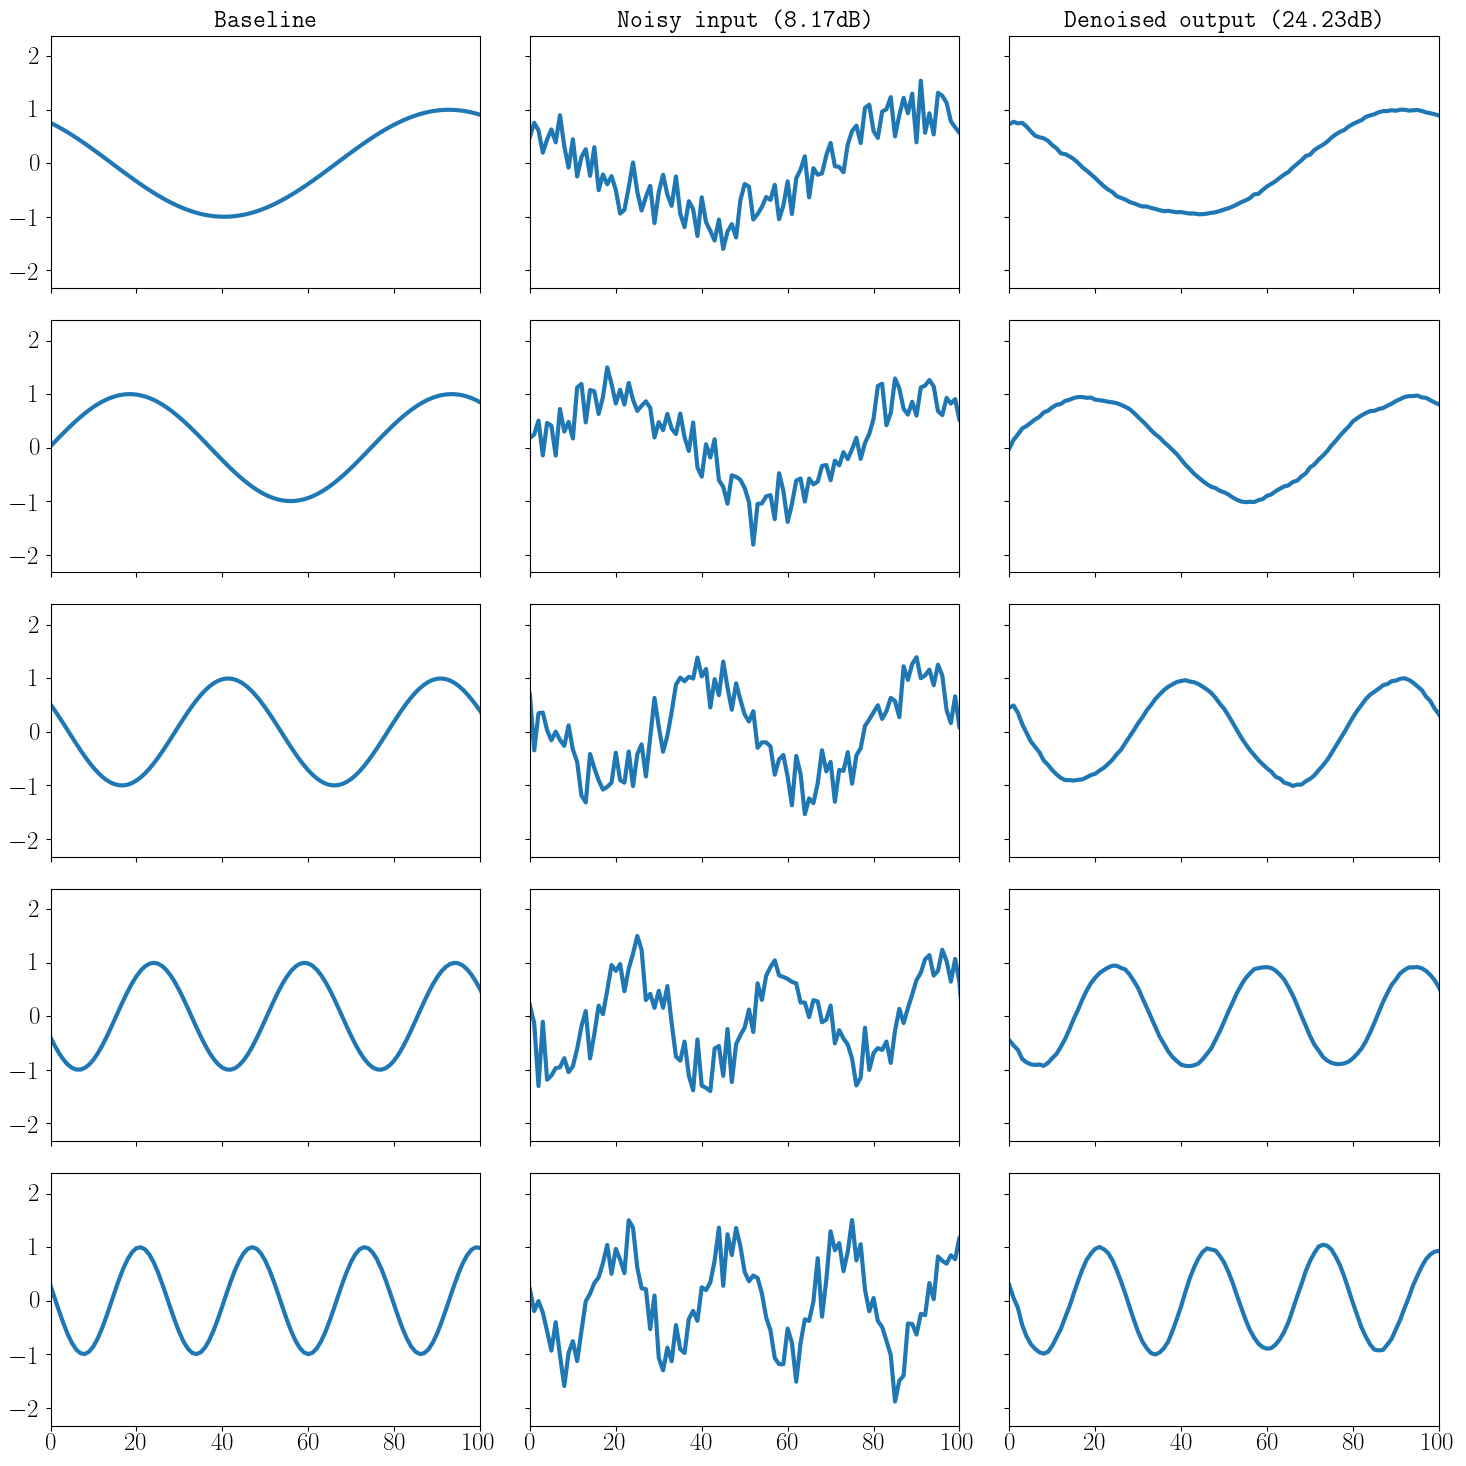

In [48]:
model.eval().cpu()
clean, noisy = data('cpu')
input_snr = SNR(noisy, clean)[1].item()
with torch.no_grad(), quantized_engine('qnnpack'):
    if sum_channels_for_input:
        denoised = model(noisy.sum(1).unsqueeze(1))
    else:
        denoised = model(noisy)
    output_snr = SNR(denoised, clean)[1].item()
    

batch_num = 1
fig, ax = plt.subplots(denoised.shape[1], 3, sharex=True, sharey=True, figsize=(15, 15))
for channel in range(denoised.shape[1]):
    ax[channel, 0].plot(clean[batch_num, channel])
    ax[channel, 1].plot(noisy[batch_num, channel])
    ax[channel, 2].plot(denoised[batch_num, channel])
    ax[channel, 0].set_xlim(0, 100)

ax[0, 0].set_title("Baseline")
ax[0, 1].set_title(f"Noisy input ({input_snr:.2f}dB)")
ax[0, 2].set_title(f"Denoised output ({output_snr:.2f}dB)")

plt.tight_layout()

## Static quantization

In [45]:
import copy
model = MyModel(channels=channels, single_input_channel=sum_channels_for_input,
                data_length=length)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')
model.eval()

model.qconfig = tq.get_default_qconfig('qnnpack')

prepare_model = tq.prepare(model, inplace=False)
for _ in range(3):
    clean, noisy = data('cpu')
    if sum_channels_for_input:
        noisy = noisy.sum(1).unsqueeze(1)
    prepare_model(noisy)
with quantized_engine('qnnpack'):
    qmodel = tq.convert(prepare_model)


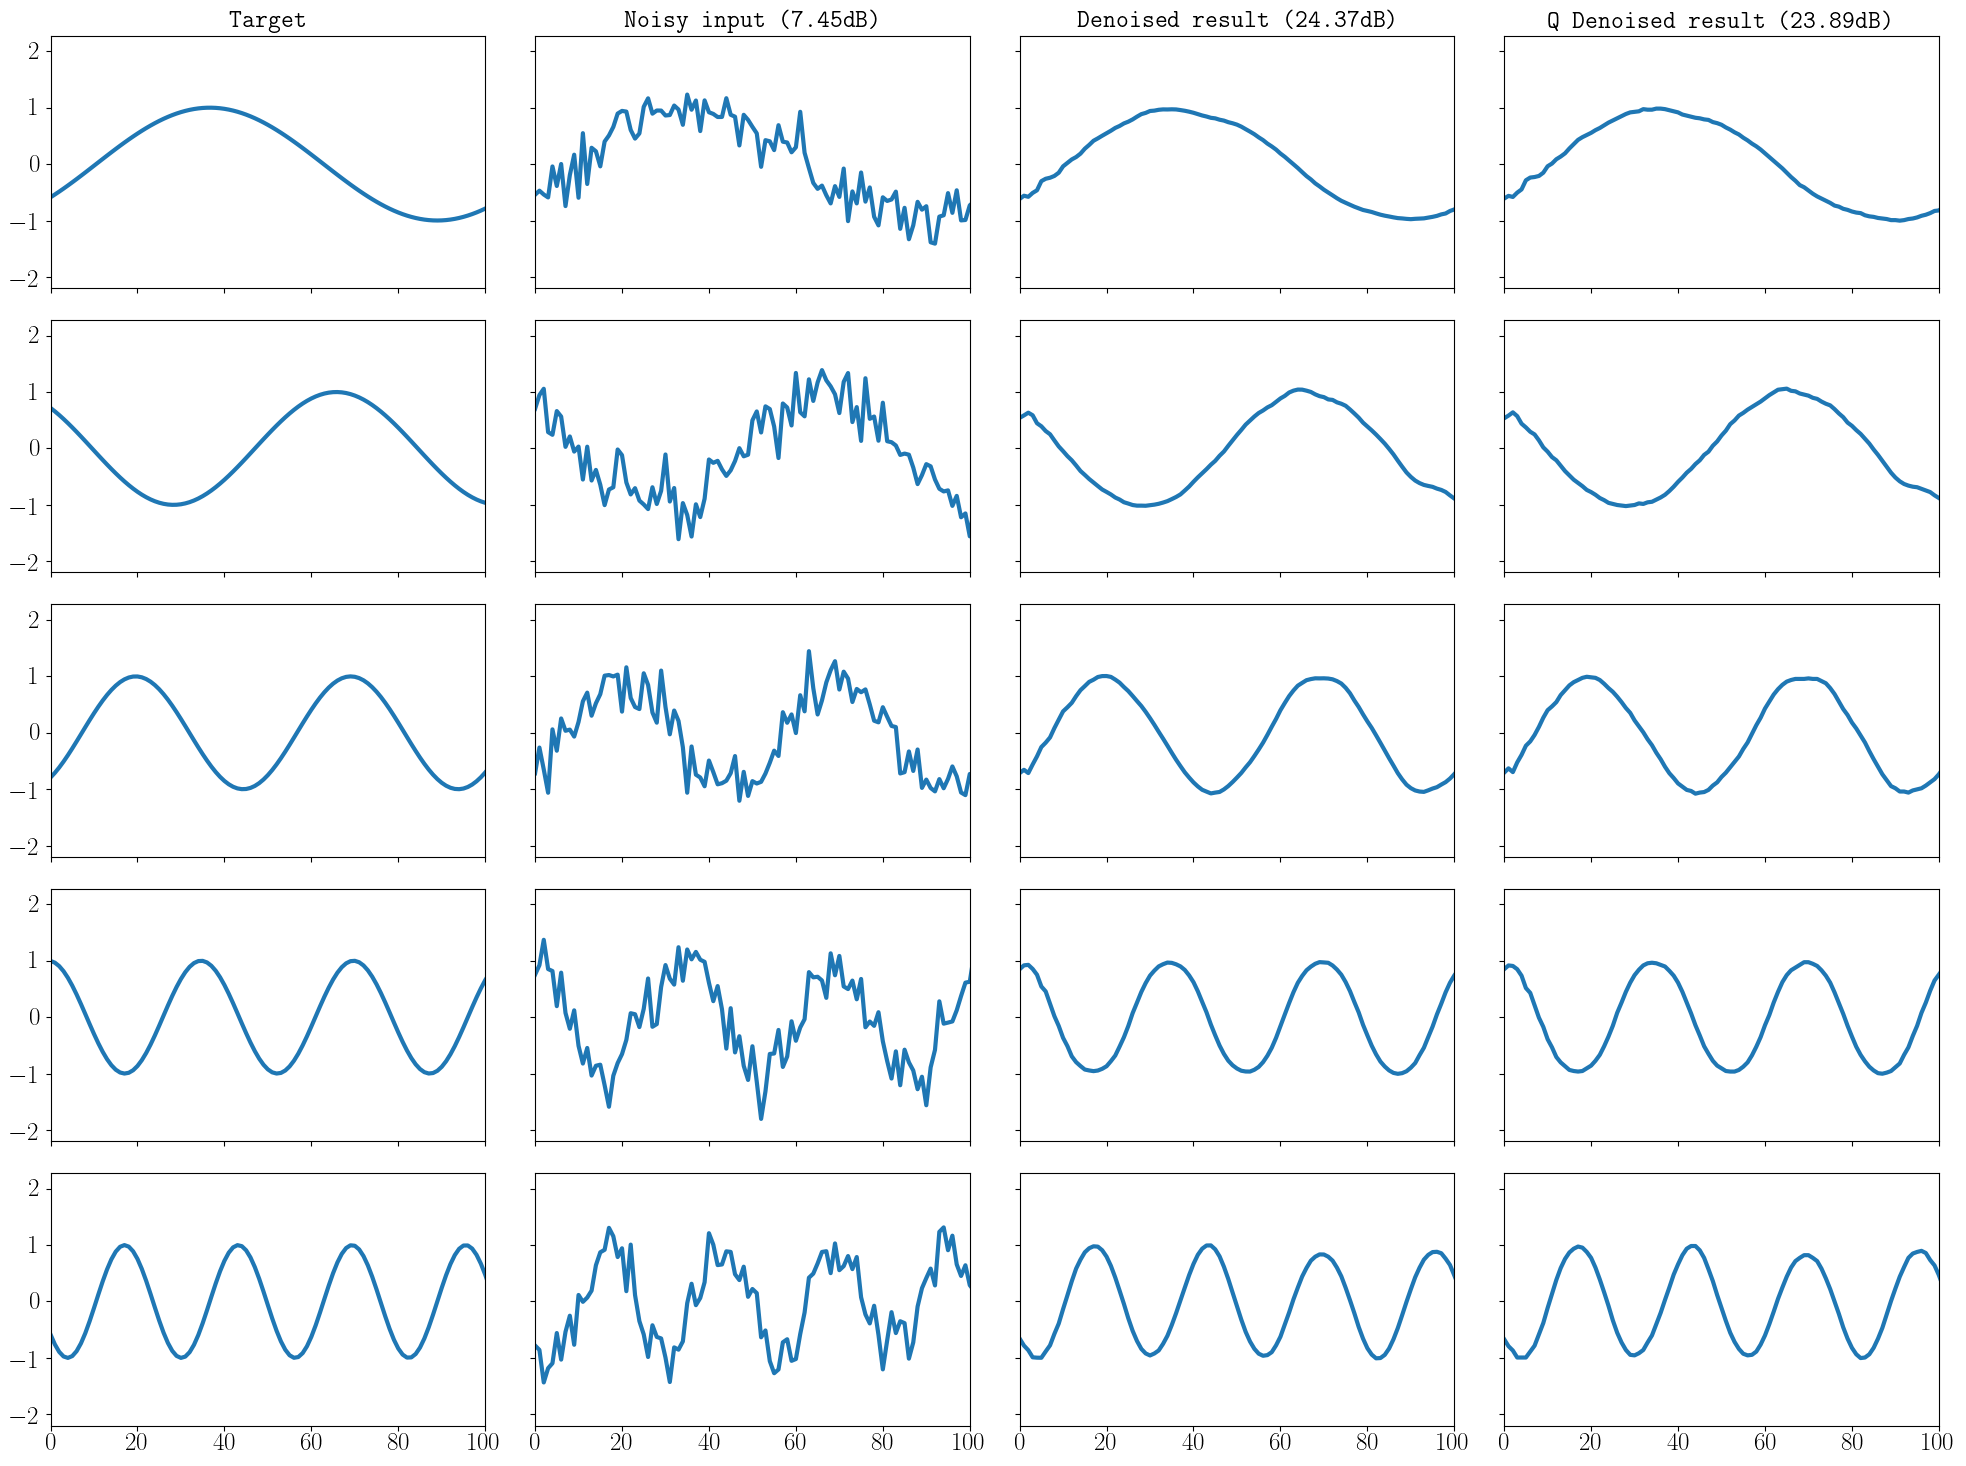

In [46]:
model.eval().cpu()
clean, noisy = data('cpu')
input_snr = SNR(clean, noisy)[1].item()

with torch.no_grad(), quantized_engine('qnnpack'):
    if sum_channels_for_input:
        denoised = model(noisy.sum(1).unsqueeze(1))
        qdenoised = qmodel(noisy.sum(1).unsqueeze(1))
    else:
        denoised = model(noisy)
        qdenoised = qmodel(noisy)

output_snr = SNR(clean, denoised)[1].item()
q_output_snr = SNR(clean, qdenoised)[1].item()

batch_num = 1
fig, ax = plt.subplots(clean.shape[1], 4, sharex=True, sharey=True, figsize=(20, 15))
for channel in range(denoised.shape[1]):
    ax[channel, 0].plot(clean[batch_num, channel])
    ax[channel, 1].plot(noisy[batch_num, channel])
    ax[channel, 2].plot(denoised[batch_num, channel])
    ax[channel, 3].plot(qdenoised[batch_num, channel])
    ax[channel, 0].set_xlim(0, 100)

ax[0, 0].set_title("Target")
ax[0, 1].set_title(f"Noisy input ({input_snr:.2f}dB)")
ax[0, 2].set_title(f"Denoised result ({output_snr:.2f}dB)")
ax[0, 3].set_title(f"Q Denoised result ({q_output_snr:.2f}dB)")

plt.tight_layout()

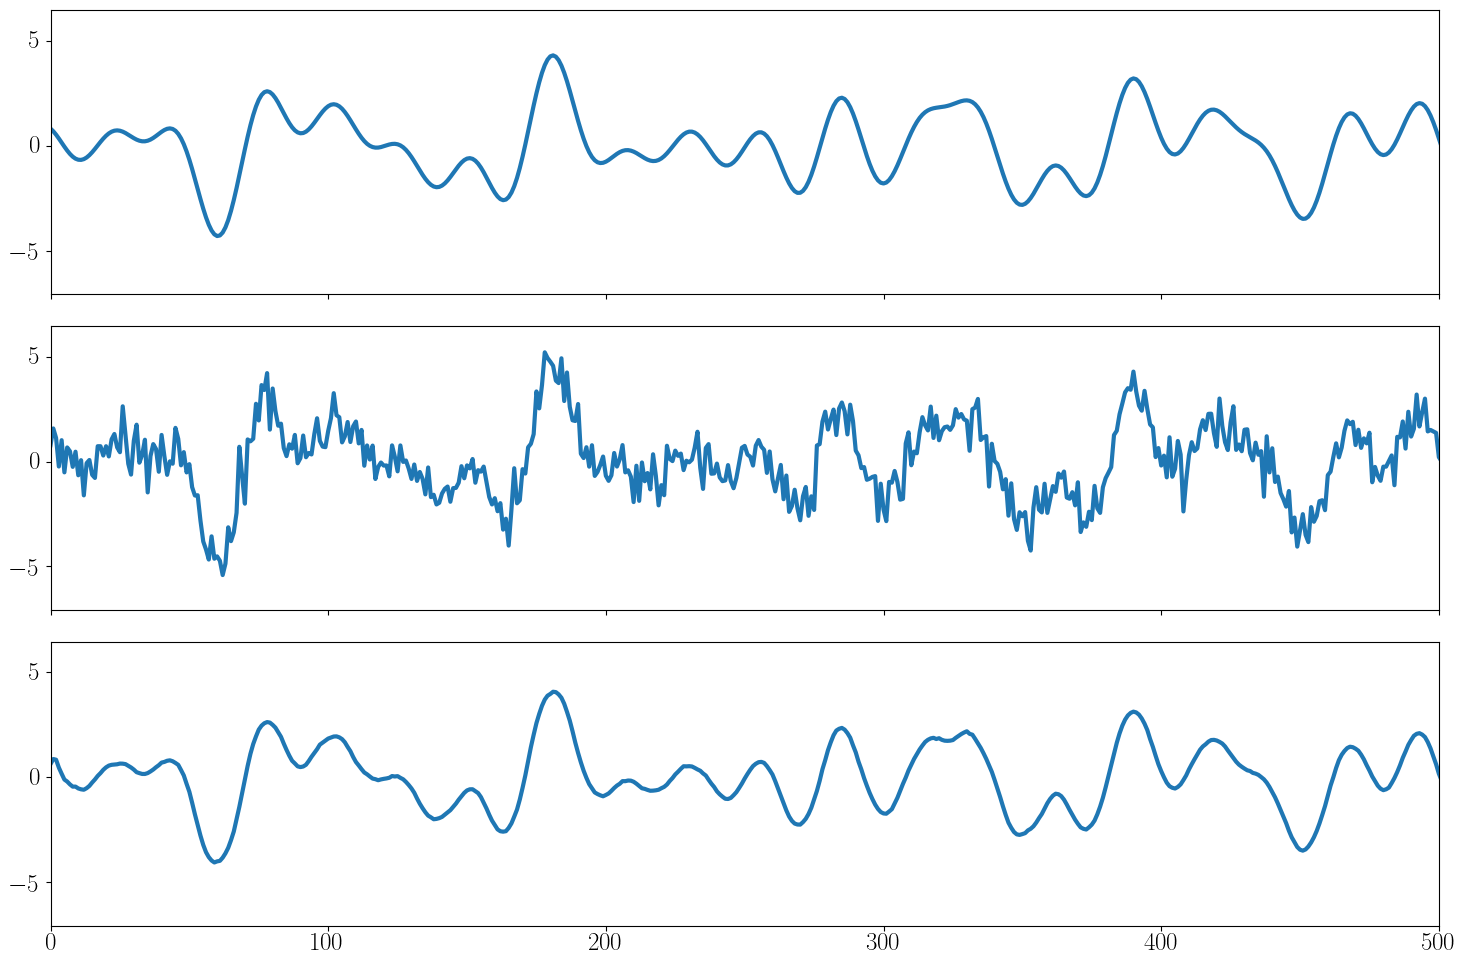

In [47]:
# Showing real input and real output here
sample_num = 0

clean, noisy = data('cpu')
clean = clean.sum(1).unsqueeze(1)
noisy = noisy.sum(1).unsqueeze(1)

with torch.no_grad():
    denoised = model(noisy)
    denoised = denoised.sum(1).unsqueeze(1)

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 10))
ax[0].plot(clean[sample_num, 0])
ax[1].plot(noisy[sample_num, 0])
ax[2].plot(denoised[sample_num, 0])

ax[0].set_xlim([0, 500])

plt.tight_layout()